# Прогнозирование оттока клиентов банка

## Описание задачи

**Цель проекта:** Разработать модель машинного обучения для прогнозирования оттока клиентов банка на основе данных об их демографических характеристиках, финансовом поведении и активности в обслуживании.

**Постановка задачи:**
Необходимо построить классификационную модель, которая по историческим данным о клиентах сможет предсказать вероятность их ухода из банка.

**Тип задачи:** бинарная классификация.

**Целевая переменная:** `Attrition_Flag` — статус клиента:

* `Existing Customer` — действующий клиент (остался в банке)
* `Attrited Customer` — ушедший клиент (прекратил сотрудничество с банком)


### Числовые признаки (14)
1. **Customer_Age** - Возраст клиента (в годах) 
2. **Dependent_count** - Количество иждивенцев (детей, членов семьи, находящихся на содержании клиента)
3. **Months_on_book** - Количество месяцев обслуживания клиента в банке
4. **Months_Inactive_12_mon** - Количество месяцев без активности за последние 12 месяцев
5. **Contacts_Count_12_mon** - Количество взаимодействий клиента с банком за последние 12 месяцев
6. **Credit_Limit** - Установленный кредитный лимит клиента 
7. **Total_Revolving_Bal** - Общий остаток задолженности по вращающемуся кредиту (revolving balance)
8. **Avg_Open_To_Buy** - Средняя сумма доступного кредитного лимита (разница между лимитом и задолженностью)
9. **Avg_Utilization_Ratio** - Среднее отношение используемого кредита к общему лимиту (индикатор нагрузки по кредиту)
10. **Total_Relationship_Count** - Общее количество продуктов банка, которыми пользуется клиент (например, кредитная карта, вклад, ипотека и т.д.)
11. **Total_Trans_Amt** - Общая сумма транзакций за последние 12 месяцев
12. **Total_Trans_Ct** - Общее количество транзакций за последние 12 месяцев
13. **Total_Amt_Chng_Q4_Q1** - Изменение общей суммы транзакций между 4-м и 1-м кварталом (показатель активности)
14. **Total_Ct_Chng_Q4_Q1** - Изменение количества транзакций между 4-м и 1-м кварталом (показатель активности)

### Категориальные признаки (5)
1. **Gender** - Пол клиента (`Male` — мужчина, `Female` — женщина)   
2. **Education_Level** - Уровень образования (`High School`, `Graduate`, `College`, `Uneducated`, `Doctorate`, и т.п.)
3. **Marital_Status** - Семейное положение (`Married`, `Single`, `Divorced`, `Unknown`)
4. **Income_Category** - Категория годового дохода (`< $40K`, `$40K - $60K`, `$60K - $80K`, `$80K - $120K`, `$120K +`, `Unknown`)
5. **Card_Category** - Тип кредитной карты (`Blue`, `Silver`, `Gold`, `Platinum`) 

Последние два признака в датасете(Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 и Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2), рассчитанные автором датасета, не учитываются при обучении модели.


# 1. Прочитать данные

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import starbars
from scipy.stats import mannwhitneyu 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, ConfusionMatrixDisplay

wr.filterwarnings('ignore')


work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_csv(work_dir / "BankChurners.csv")
columns_to_drop = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                  'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

df = df.drop(columns_to_drop, axis=1)

print(f"Уникальные классы: {df['Attrition_Flag'].unique()}")
print(f"Количество классов: {df['Attrition_Flag'].nunique()}")

delete_columns = ['CLIENTNUM', 'Attrition_Flag']

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [column for column in numeric_columns if column not in delete_columns]

categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = [column for column in categorical_columns if column not in delete_columns]

print(f"\nЧисловые признаки ({len(numeric_columns)}):")
print(numeric_columns)
print(f"Категориальные признаки ({len(categorical_columns)}):")
print(categorical_columns)

Уникальные классы: ['Existing Customer' 'Attrited Customer']
Количество классов: 2

Числовые признаки (14):
['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
Категориальные признаки (5):
['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [3]:
df



,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


# 2. Разбить данные на обучающую и тестовую выборки
# 5. Обработка категориальных признаков
# 6. Нормализация данных для kNN

In [4]:
delete_columns = ['CLIENTNUM', 'Attrition_Flag']
def split_data(
    df_dataset,
    cols,
    scaler,
    target_col='Attrition_Flag',
    test_size=0.2,
    valid_size=0.2,
    random_state=42,
    get_valid_data=False
):
    X_train, X_test, y_train, y_test = train_test_split(
        df_dataset[cols],
        df_dataset[target_col],
        test_size=test_size,
        random_state=random_state,
        stratify=df_dataset[target_col]
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=cols, index=X_test.index)
    
    if not get_valid_data:
        return X_train, X_test, y_train, y_test

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=valid_size,
        random_state=random_state
    )
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True) #one-hot кодирование категориальных признаков
#df_encoded.to_excel(work_dir / "df_encoded.xlsx", index=False)
features = [col for col in df_encoded.columns if col != 'Attrition_Flag']

scaler = StandardScaler()
X_train, X_test, y_train, y_test = split_data(df_encoded, features, scaler=scaler)  


# 3. Визуализация данных и вычисление основных характеристик

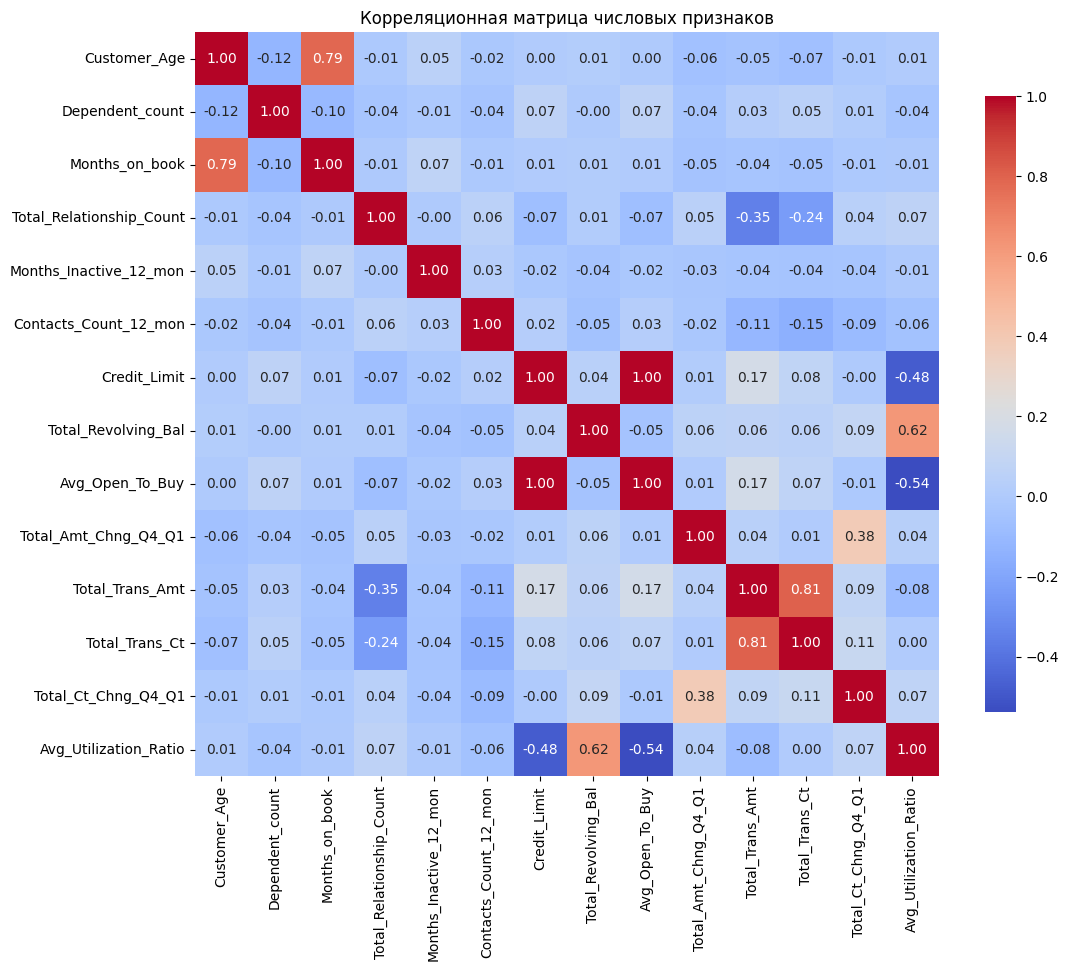

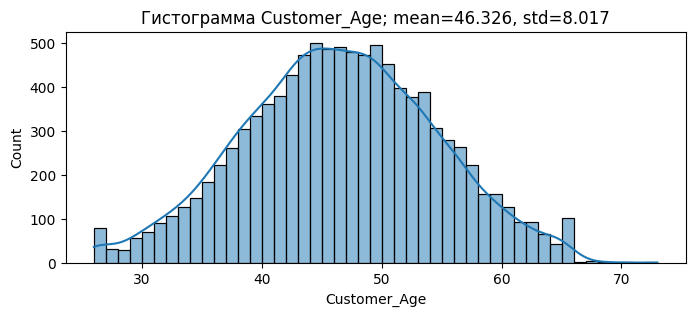

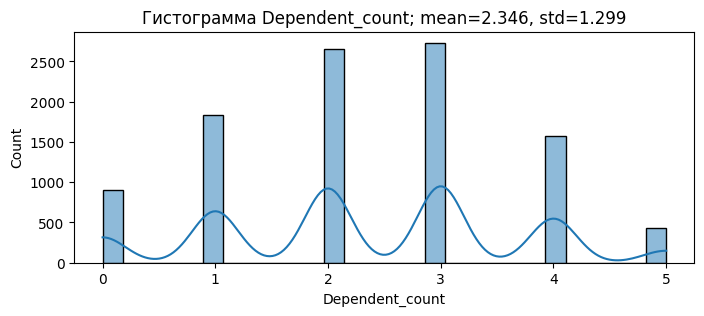

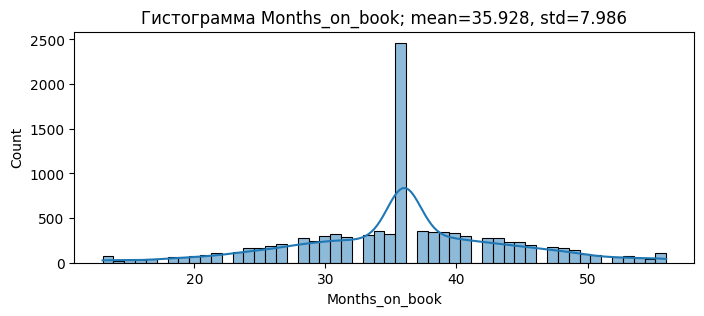

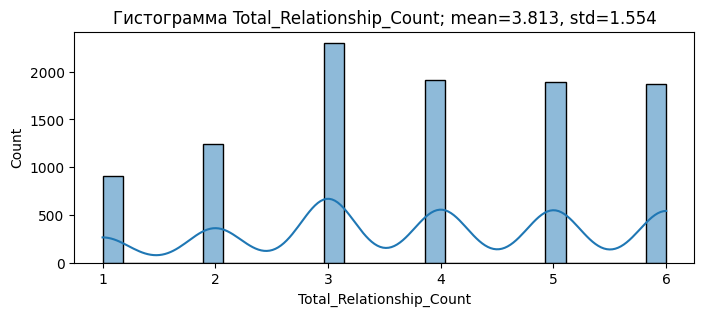

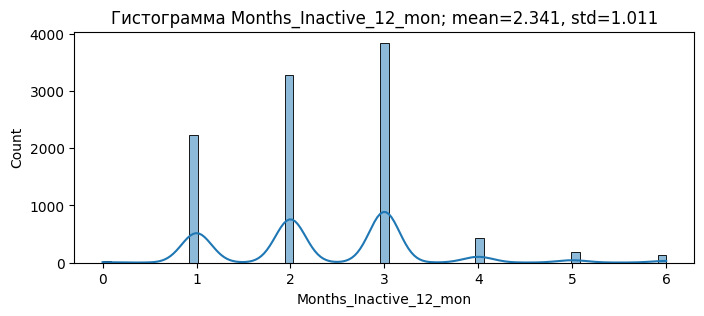

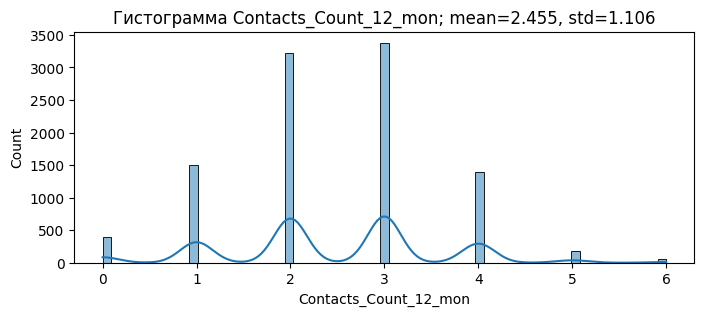

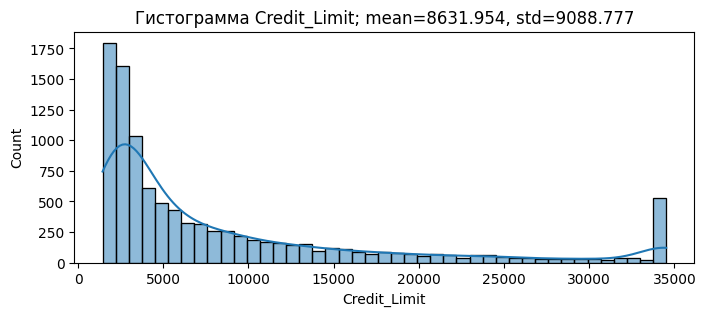

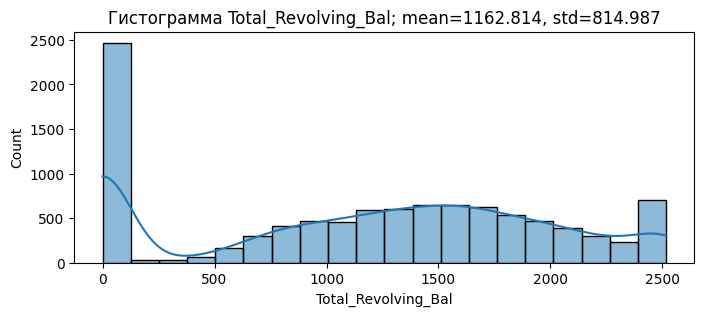

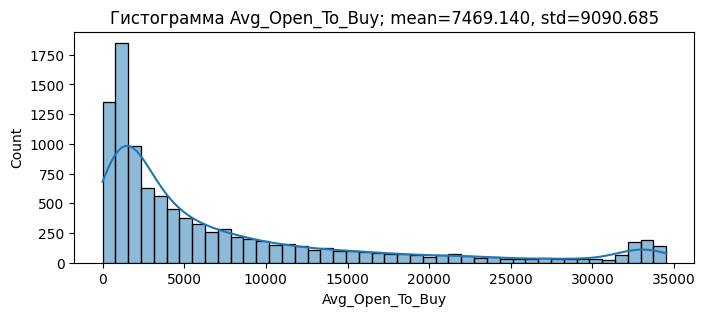

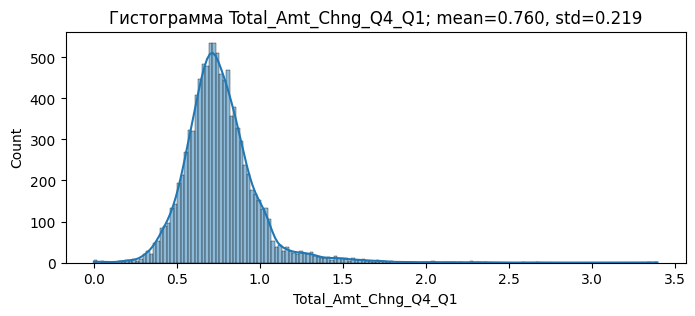

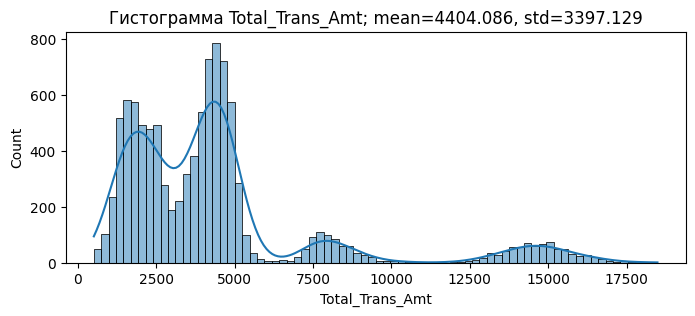

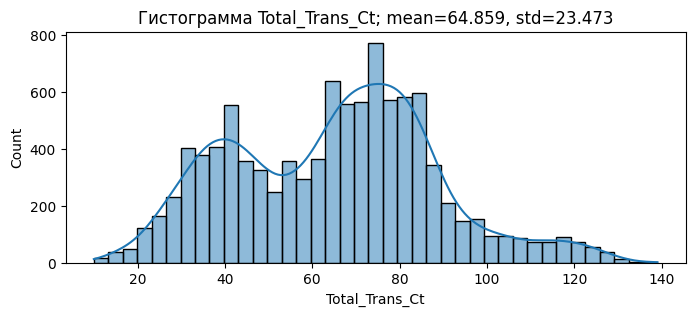

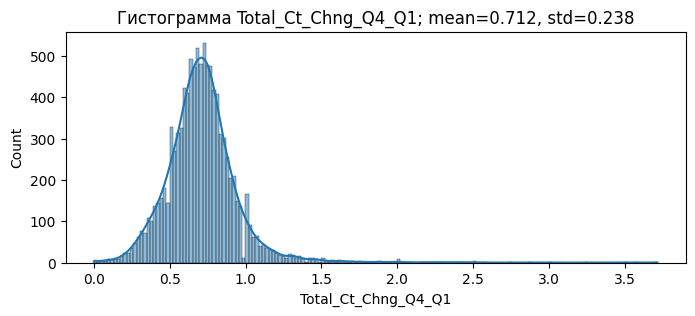

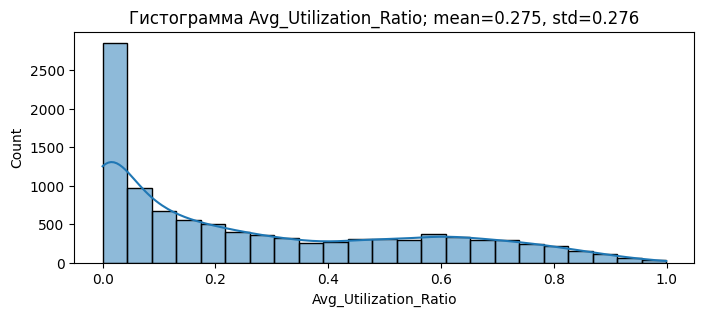

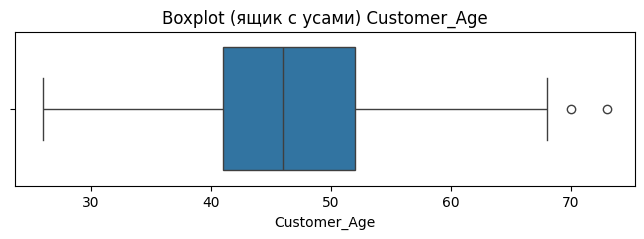

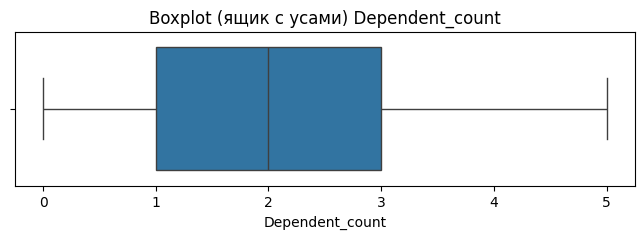

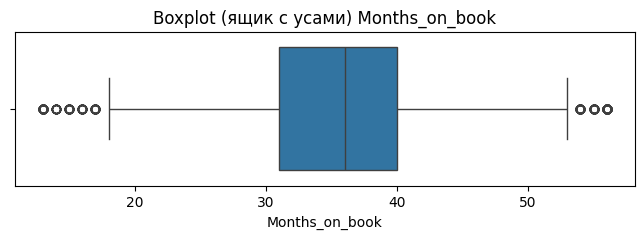

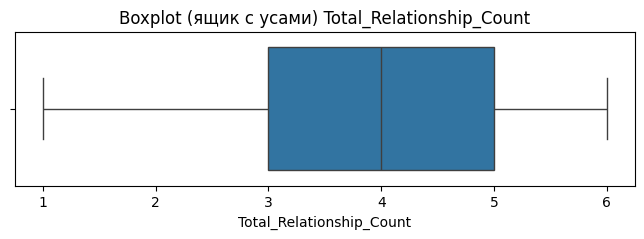

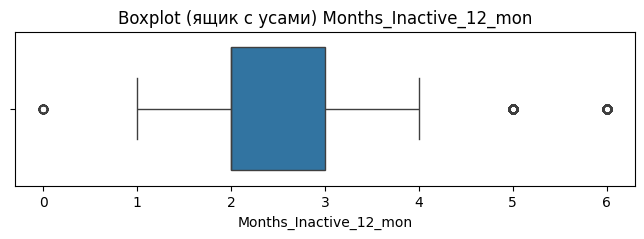

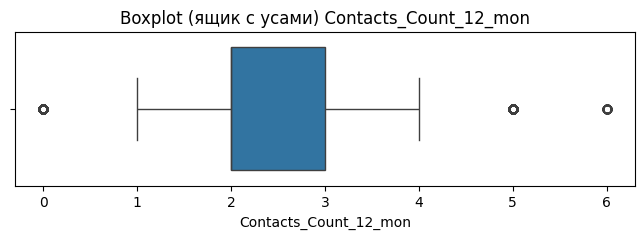

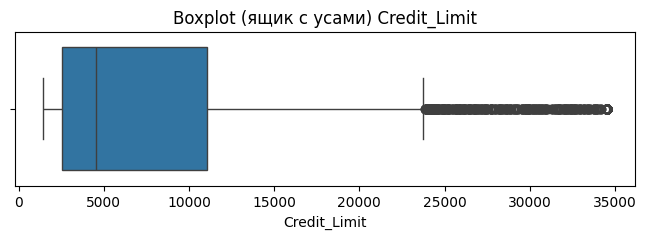

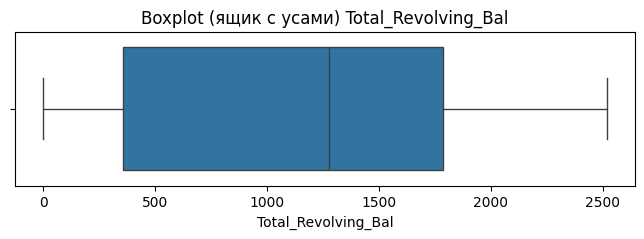

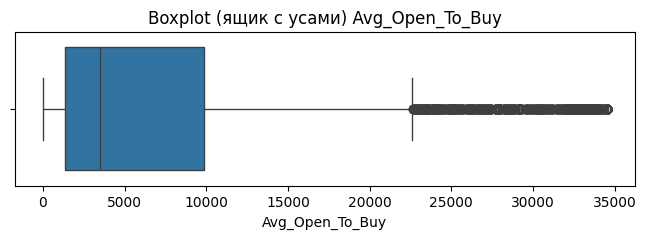

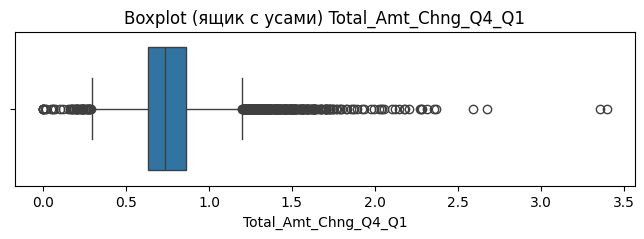

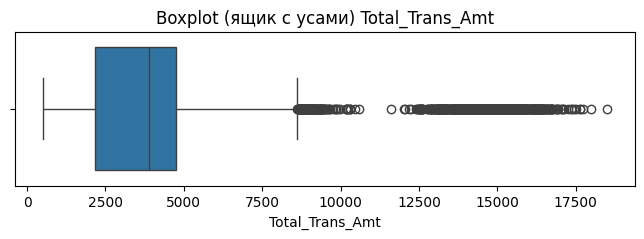

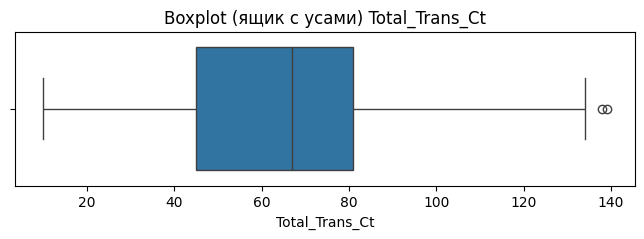

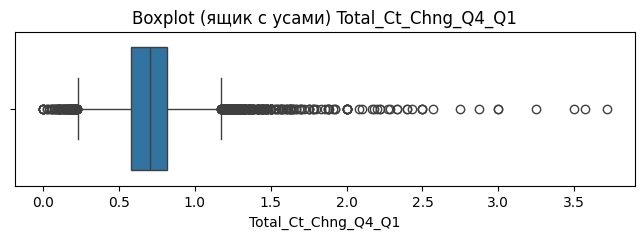

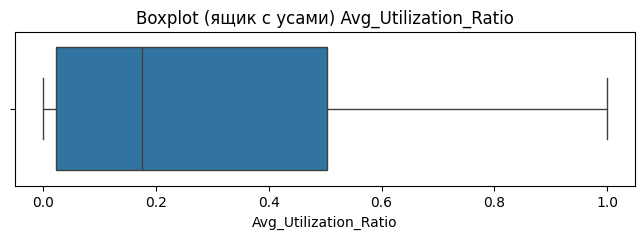

Наиболее сильные корреляции (|r| > 0.6):
            Признак 1             Признак 2  Корреляция
         Credit_Limit       Avg_Open_To_Buy    0.995981
      Avg_Open_To_Buy          Credit_Limit    0.995981
      Total_Trans_Amt        Total_Trans_Ct    0.807192
       Total_Trans_Ct       Total_Trans_Amt    0.807192
         Customer_Age        Months_on_book    0.788912
       Months_on_book          Customer_Age    0.788912
  Total_Revolving_Bal Avg_Utilization_Ratio    0.624022
Avg_Utilization_Ratio   Total_Revolving_Bal    0.624022

Средние значения и стандартные отклонения
                              mean       std
Customer_Age                46.326     8.017
Dependent_count              2.346     1.299
Months_on_book              35.928     7.986
Total_Relationship_Count     3.813     1.554
Months_Inactive_12_mon       2.341     1.011
Contacts_Count_12_mon        2.455     1.106
Credit_Limit              8631.954  9088.777
Total_Revolving_Bal       1162.814   814.987
Avg_Ope

In [8]:
corr = df[numeric_columns].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink':.8})
plt.title('Корреляционная матрица числовых признаков')
plt.show()


for col in numeric_columns:
    plt.figure(figsize=(8,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Гистограмма {col}; mean={df[col].mean():.3f}, std={df[col].std():.3f}")
    plt.show()

for col in numeric_columns:
    plt.figure(figsize=(8,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot (ящик с усами) {col}")
    plt.show()


print("Наиболее сильные корреляции (|r| > 0.6):")
strong_corrs = corr.where(abs(corr) > 0.6).stack().reset_index()
strong_corrs.columns = ['Признак 1', 'Признак 2', 'Корреляция']
strong_corrs = strong_corrs[strong_corrs['Признак 1'] != strong_corrs['Признак 2']]
print(strong_corrs.sort_values('Корреляция', ascending=False).to_string(index=False))
      
print("\nСредние значения и стандартные отклонения")
stats_df = df[numeric_columns].agg(['mean', 'std']).T
print(stats_df.round(3).to_string())

*Высокая корреляция между `Total_Trans_Amt` и `Total_Trans_Ct` (r ≈ 0.81) показывает, что клиенты с большим количеством транзакций совершают и более крупные суммы операций. Умеренная связь между `Customer_Age` и `Months_on_book` (r ≈ 0.79) логична — старшие клиенты дольше обслуживаются в банке. Связь `Total_Revolving_Bal` с `Avg_Utilization_Ratio` (r ≈ 0.62) отражает зависимость использования лимита от баланса. Средние значения показывают типичного клиента: возраст около 46 лет, 2 иждивенца, стаж обслуживания ~36 месяцев, 3–4 банковских продукта. Средние финансовые показатели: кредитный лимит ~8600, остаток лимита ~7400, средний баланс ~1100, средняя активность ~65 транзакций и 4400 долларов по операциям. Большие стандартные отклонения (std сопоставимо с mean) для лимитов и сумм транзакций указывают на высокую вариативность — в выборке присутствуют как очень активные, так и малопользующиеся клиенты, что объясняет наличие выбросов на графиках.*

#

# 4. Обработка пропущенных значений (таковых нет)

In [12]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# 7. Запуск классификатора (KNN)
*Выбрал kNN, поскольку KNN не требует сложных предположений о данных - он просто сравнивает клиентов по схожести признаков. Подходит как для числовых, так и категориальных признаков (после One-Hot кодирования и масштабирования). А также не гигантский датасет позволяет использовать KNN - не будет долго считать.*

In [13]:
grid_space = {'n_neighbors': [5, 10, 15, 20, 25, 30],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']
}

grid = GridSearchCV(KNeighborsClassifier(), 
                    grid_space, 
                    cv=5, 
                    #scoring='balanced_accuracy',
                    scoring='recall_weighted',
                    n_jobs=-1,
                    verbose=1
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший результат:", grid.best_score_)


knn = KNeighborsClassifier(**grid.best_params_) #обучяем модель
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)  # используем модель на обучающей выборке
train_acc = accuracy_score(y_train, y_train_pred)
print("Точность на обучающей выборке:", train_acc)
print("Ошибка на обучающей выборке:", 1- train_acc)
print("\n\nОтчет классификации (train):\n", classification_report(y_train, y_train_pred))

y_test_pred = knn.predict(X_test)  #на тестовой
test_acc = accuracy_score(y_test, y_test_pred)
print("Точность на тестовой выборке:", test_acc)
print("Ошибка на тестовой выборке:", 1- test_acc)
print("\n\nОтчет классификации (test):\n", classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}
Лучший результат: 0.8924826162786269
Точность на обучающей выборке: 0.9107517590420936
Ошибка на обучающей выборке: 0.0892482409579064


Отчет классификации (train):
                    precision    recall  f1-score   support

Attrited Customer       0.88      0.51      0.65      1302
Existing Customer       0.91      0.99      0.95      6799

         accuracy                           0.91      8101
        macro avg       0.90      0.75      0.80      8101
     weighted avg       0.91      0.91      0.90      8101

Точность на тестовой выборке: 0.8889437314906219
Ошибка на тестовой выборке: 0.11105626850937811


Отчет классификации (test):
                    precision    recall  f1-score   support

Attrited Customer       0.76      0.45      0.56       325
Existing Customer       0.90      0.97      0.94      1701

         accuracy       

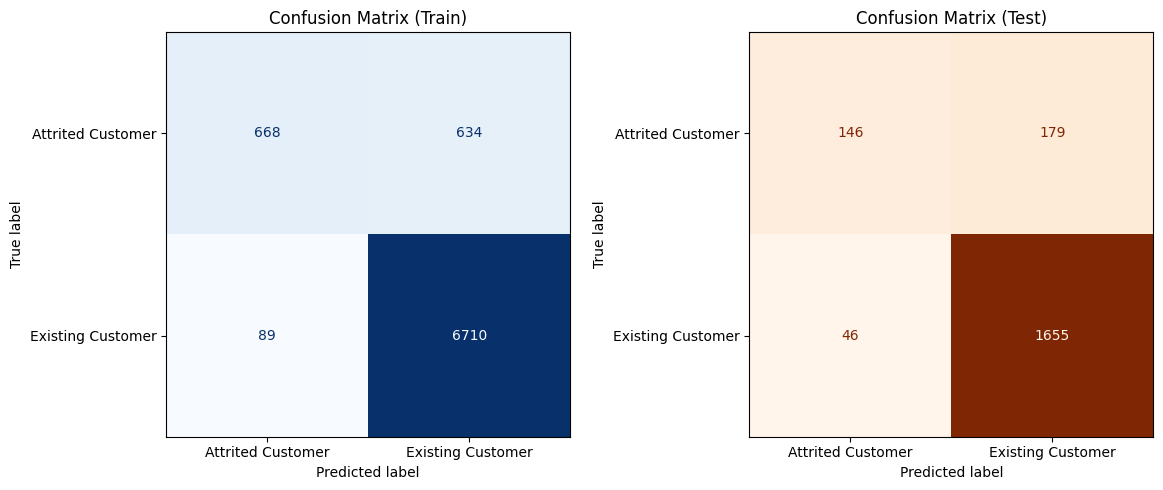

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    knn, X_train, y_train, cmap="Blues", colorbar=False, ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Train)")

ConfusionMatrixDisplay.from_estimator(
    knn, X_test, y_test, cmap="Oranges", colorbar=False, ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Test)")

plt.tight_layout()
plt.show()

*Модель точна при предсказании ухода (precision = 0.76), но пропускает половину уходящих (recall = 0.45).*

# 12. Общие выводы
Модель KNN с оптимальными параметрами показала достаточно хорошее качество (Accuracy ≈ 0.88), то есть модель правильно классифицирует ~88% клиентов. Однако recall по ушедшим клиентам ниже (~0.45–0.51), то есть модель не всегда распознает всех клиентов, склонных уйти, но делает это с хорошей точностью (precision 0.76-0.88).
Для повышения эффективности необходимо работать с балансом классов и сравнивать результаты с более сложными моделями.